# Install Dependencies

In [307]:
pip install 'stable-baselines3[extra]' gym-anytrading gymnasium tensorflow finta

Note: you may need to restart the kernel to use updated packages.


# Install MacOS Dependencies

In [291]:
pip install tensorflow-macos tensorflow-metal

Note: you may need to restart the kernel to use updated packages.


# Import Dependencies

In [308]:
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv

from finta import TA

from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import PPO, A2C

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from enum import Enum

# Define Constants

In [396]:
# available algorithms for training
class Algorithm(Enum):
    PPO = 'ppo'
    A2C = 'a2c'

# algorithm to use for training
SELECTED_ALGORITHM = Algorithm.PPO

# determine algorithm function to use
ALGO_FN = A2C if SELECTED_ALGORITHM == Algorithm.A2C else PPO

# path to save trained model data
MODEL_DATA_PATH = 'model/%s_stocks.zip' % SELECTED_ALGORITHM.value 

# rolling window size for training
WINDOW_SIZE = 12 

# size of rendered charts
CHART_SIZE = (15, 6) 

# timesteps for training the model
TRAINING_TIMESTEPS = 200000 

# trailing number of frames to test model against
# if you have 200 rows, and this is set to 50, the first 150 frames are for training and the last 50 are for testing)
TEST_FRAME_SIZE = 50 

# Import Trading Data

In [390]:
# CSV downloaded from: https://www.marketwatch.com/investing/stock/cfg/download-data
df = pd.read_csv('data/Download Data - STOCK_US_XNYS_CFG.csv')

print('Total rows:', df.shape[0])
df.head()

Total rows: 251


,Date,Open,High,Low,Close,Volume
0,12/11/2023,29.40,29.79,29.16,29.59,"3,222,813"
1,12/08/2023,29.33,29.90,29.12,29.61,"4,002,800"
2,12/07/2023,28.93,29.35,28.78,29.16,"3,254,849"
3,12/06/2023,29.40,30.07,28.72,28.76,"6,707,243"
4,12/05/2023,28.33,29.33,28.19,29.06,"9,472,810"


# Clean Trading Data

In [391]:
# convert date string to a datetime object
df['Date'] = pd.to_datetime(df['Date'])

# convert Volume to a float
df['Volume'] = df['Volume'].apply(lambda val: float(val.replace(',', '')))

# set index and sort
df.set_index('Date', inplace=True)
df.sort_values('Date', ascending=True, inplace=True)

df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2022-12-12,39.90,40.55,39.33,40.43,3753325.0
2022-12-13,41.35,41.59,39.61,39.90,4687774.0
2022-12-14,39.89,40.00,38.88,39.06,4484282.0
2022-12-15,38.38,38.75,38.14,38.32,5140246.0
2022-12-16,37.92,38.41,37.75,38.33,6154369.0


# Calculate SMA, RSI, and OBV

In [392]:
# calculate additional signals
df['SMA'] = TA.SMA(df, WINDOW_SIZE) # Simple Moving Average
df['RSI'] = TA.RSI(df) # Relative Strength Index
df['OBV'] = TA.OBV(df) # On Balance Volume

# replace invalid numbers with zeros
df.fillna(0, inplace=True)

df.head(WINDOW_SIZE)

,Open,High,Low,Close,Volume,SMA,RSI,OBV
Date,,,,,,,,
2022-12-12,39.90,40.55,39.33,40.43,3753325.0,0.000000,0.000000,0.0
2022-12-13,41.35,41.59,39.61,39.90,4687774.0,0.000000,0.000000,-4687774.0
2022-12-14,39.89,40.00,38.88,39.06,4484282.0,0.000000,0.000000,-9172056.0
2022-12-15,38.38,38.75,38.14,38.32,5140246.0,0.000000,0.000000,-14312302.0
2022-12-16,37.92,38.41,37.75,38.33,6154369.0,0.000000,0.541777,-8157933.0
2022-12-19,38.29,38.77,37.88,38.20,2836544.0,0.000000,0.503581,-10994477.0
2022-12-20,38.34,38.66,38.00,38.05,4141793.0,0.000000,0.463019,-15136270.0
2022-12-21,38.59,39.09,38.56,38.70,3831827.0,0.000000,27.656522,-11304443.0
2022-12-22,38.37,38.94,37.97,38.89,3047772.0,0.000000,33.385467,-8256671.0


# Create New Environment

In [379]:
# define custom function to include additional signal data
def process_data_with_signals(env):
    # determine start and end bounds
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]

    # gather price and signal data
    prices = env.df.loc[:, 'Low'].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Low', 'Volume', 'SMA', 'RSI', 'OBV']].to_numpy()[start:end]
    
    return prices, signal_features

# define custom environment which extends the default
class MyCustomEnv(StocksEnv):
    # override default environment function with custom one
    _process_data = process_data_with_signals

# Build Environment

Total Profit: -59.47%


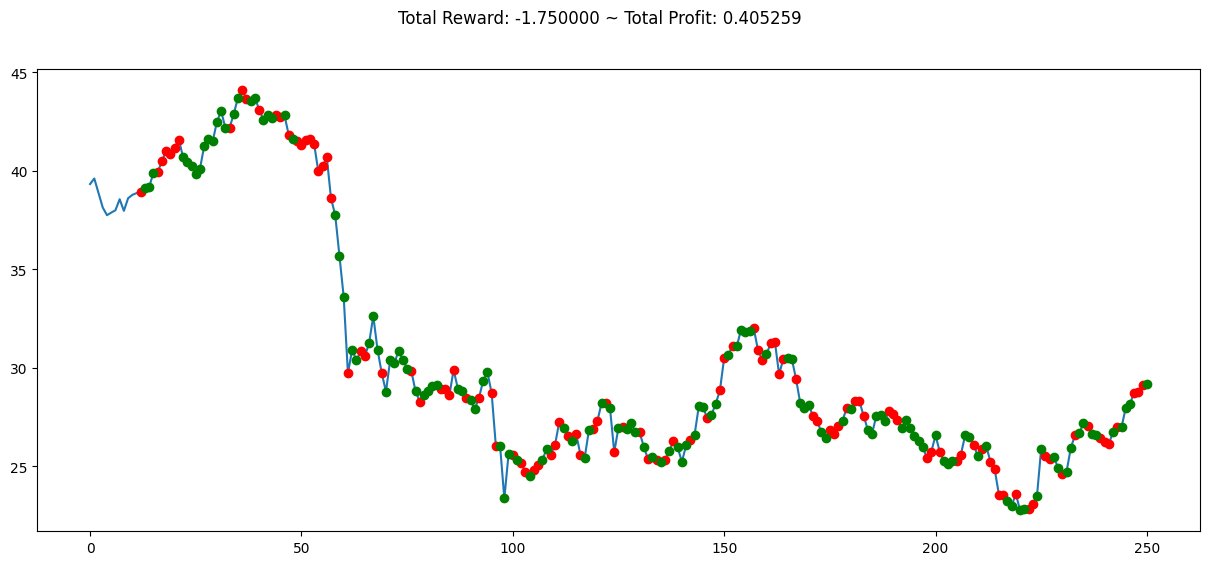

In [406]:
# initialize custom environment
env = MyCustomEnv(df=df, window_size=WINDOW_SIZE, frame_bound=(WINDOW_SIZE, df.shape[0]))
obs = env.reset()

# iterate over data frames
while True:
    # generate a random action
    action = env.action_space.sample()

    # evaluate the chosen action against the data
    obs, reward, terminated, truncated, info = env.step(action)

    # exit and print results
    if terminated or truncated:
        print("Total Profit: %s%%" % round((info['total_profit'] - 1) * 100, 2))
        break

# generate chart and plot data
plt.figure(figsize=CHART_SIZE)
env.unwrapped.render_all()
plt.show()

# Train Model Against a Subset of the Data

In [343]:
# initialize custom environment
env_maker = lambda: MyCustomEnv(df=df, window_size=12, frame_bound=(WINDOW_SIZE, df.shape[0] - TEST_FRAME_SIZE))

# train model using algorithm against data
model = ALGO_FN('MlpPolicy', env=DummyVecEnv([env_maker]), verbose=1, device="auto")
model.learn(total_timesteps=TRAINING_TIMESTEPS)

Using cpu device
-----------------------------
| time/              |      |
|    fps             | 5826 |
|    iterations      | 1    |
|    time_elapsed    | 0    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 3878         |
|    iterations           | 2            |
|    time_elapsed         | 1            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0073691877 |
|    clip_fraction        | 0.013        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.689       |
|    explained_variance   | -0.108       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.13         |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00535     |
|    value_loss           | 2.2          |
------------------------------------------

# Save Model Data

In [344]:
model.save(MODEL_DATA_PATH)

# Load Saved Model Data

In [345]:
model = ALGO_FN.load(MODEL_DATA_PATH)

# Test Model Against The Remaining Subset of Data

Total Profit: 17.16%


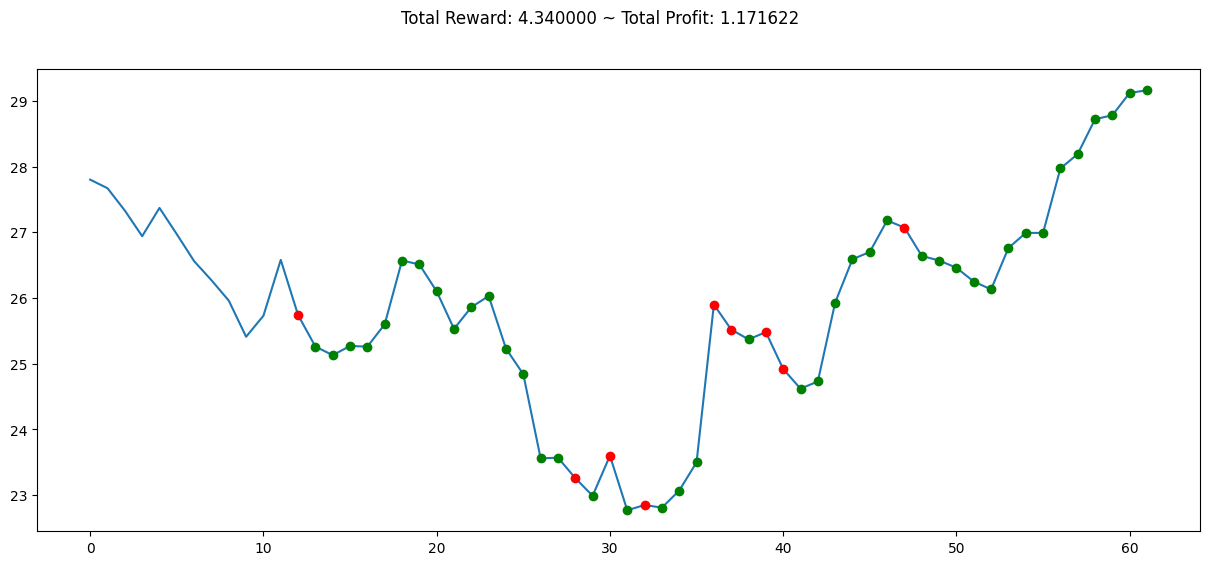

In [405]:
# initialize custom environment
env = MyCustomEnv(df=df, window_size=12, frame_bound=(df.shape[0] - TEST_FRAME_SIZE, df.shape[0]))
obs, _ = env.reset()

# iterate over data frames
while True:
    # have model predict the action to take based on the current observable data
    action, _states = model.predict(obs)

    # evaluate the chosen action against the data
    obs, reward, terminated, truncated, info = env.step(action)
    
    # exit and print results
    if terminated or truncated:
        print("Total Profit: %s%%" % round((info['total_profit'] - 1) * 100, 2))
        break

# generate chart and plot data
plt.figure(figsize=CHART_SIZE)
env.unwrapped.render_all()
plt.show()